In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os
import pickle

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/global/homes/z/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
test_indices = indices_dict['test']

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


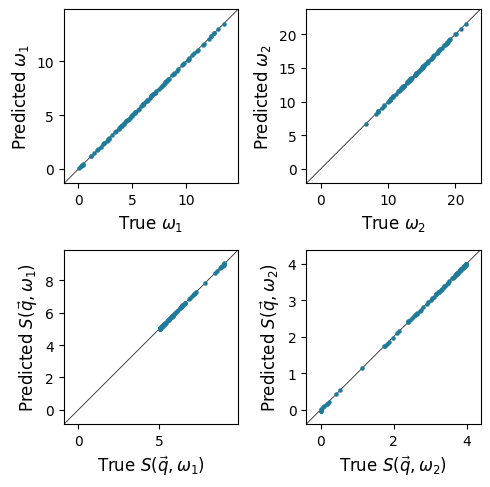

In [4]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test).detach()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [5]:
import optbayesexpt as obe
from src.utils_model import construct_fc_net, array2tensor, tensor2array
from src.utils_convolution import interp_nb, get_I_conv
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt

In [6]:
from src.utils_general import prepare_sample

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [7]:
from tqdm import tqdm

RUN_NUMBERs = ['RUN_1', 'RUN_2', 'RUN_3', 'RUN_4', 'RUN_5']
TASK_NAMEs = ['gd', 'baseline', 'random', 'sequential']

gamma = 0.1
pulse_width = 0.2
noise_level = 10.0
N_steps_bayes = 200
normalize_to_value = 100

print(f"task for pulse_width {pulse_width} and noise_level {noise_level}")

task for pulse_width 0.2 and noise_level 10.0


In [8]:
times = np.arange(0, 5, 0.01)
parameters = (
    np.random.uniform(-3.0, -1.0, 1001),
    np.random.uniform(-1.0,  0.0, 1001),
    np.random.uniform( 0.0,  1.0, 1001)
    )

In [9]:
from multiprocessing import Process, Manager, Pool
# from torch.multiprocessing import Pool, Manager, Process, set_start_method
# set_start_method('spawn')
from functools import partial
from itertools import repeat

In [10]:
def updata_dict_for_idx(idx, d, settings, selection_method, TASK_NAME, device):
    d[idx] = {}
    param_true, func_I_conv, func_I_noconv = prepare_sample(
            X_test[idx], Y_test[idx], gamma, times, pulse_width=pulse_width, normalize_to_value=normalize_to_value)
    obe_sim = obe.MeasurementSimulator(
        lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level)
    
    bayes = BayesianInference(
        model_spec, settings, parameters,
        pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
        model_uncertainty=False, device=device)
    bayes.obe_model.set_selection_method(selection_method)

    if TASK_NAME == 'gd':
        particles_hist, p_weights_hist, errors = bayes.run_N_steps_OptBayesExpt_w_GD(
            N_steps_bayes, obe_sim, N_GD=200, lr=1e-3, ret_particles=True, verbose=False, gd_seperation=50, error_criterion=150)
    else:
        particles_hist, p_weights_hist, errors = bayes.run_N_steps_OptBayesExpt_wo_GD(
            N_steps_bayes, obe_sim, ret_particles=True, verbose=False)
    param_mean = np.asarray(bayes.param_mean)
    param_std = np.asarray(bayes.param_std)

    d[idx]['param_mean'] = param_mean[None]
    d[idx]['param_std'] = param_std[None]
    d[idx]['param_true'] = param_true

    d[idx]['measurement_errors'] = errors
    _measurement_settings, _measurements = bayes.get_all_measurements()
    d[idx]['measurement_settings'] = _measurement_settings
    d[idx]['measurements'] = _measurements

    d[idx]['particles'] = particles_hist
    d[idx]['particle_weights'] = p_weights_hist

In [11]:
# def perform_task(TASK_NAME, RUN_NUMBER):

#     if TASK_NAME in ['baseline', 'gd']:
#         selection_method = 'optimal'
#         settings = (times, )
#     elif TASK_NAME == 'random':
#         selection_method = 'random'
#         settings = (times, )
#     elif TASK_NAME == 'sequential':
#         selection_method = 'sequential'
#         settings = (np.linspace(times.min(), times.max(), N_steps_bayes), )

#     SAVE_NAME = f"bayesian_{TASK_NAME}_pw-{pulse_width}_nl-{noise_level}_Nb-{N_steps_bayes}"
#     print(f"SAVE_NAME is {SAVE_NAME}")

#     manager = Manager()
#     d = manager.dict()

#     func = partial(updata_dict_for_idx, settings=settings, selection_method=selection_method, TASK_NAME=TASK_NAME, device='cpu')

#     pool = Pool(5)

#     pool.map(func, range(len(X_test)))

    # for key in comparison_dict.keys():
    #     comparison_dict[key] = np.vstack(comparison_dict[key])

    # SAVE_DIR = f'/pscratch/sd/z/zhantao/BayesExpSteering/benchmarks/{RUN_NUMBER}'
    # if not os.path.exists(SAVE_DIR):
    #     os.makedirs(SAVE_DIR)
    # with open(f'{SAVE_DIR}/{SAVE_NAME}.pkl', 'wb') as f:
    #     pickle.dump(comparison_dict, f)

In [12]:
task_name = TASK_NAMEs[0]
selection_method = 'optimal'
settings = (times, )

manager = Manager()
d = manager.dict()

func = partial(updata_dict_for_idx, d=d, settings=settings, selection_method=selection_method, TASK_NAME=task_name, device='cuda')

pool = Pool(5)

pool.map(func, range(2))

/global/u2/z/zhantao/Projects/ML_Sqt/topo-spin-Sqt-ML/src/utils_convolution.py:16: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):
/global/u2/z/zhantao/Projects/ML_Sqt/topo-spin-Sqt-ML/src/utils_convolution.py:16: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):
/global/u2/z/zhantao/Projects/ML_Sqt/topo-spin-Sqt-ML/src/bayes.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach())
/global/u2/z/zhantao/Projects/ML_Sqt/topo-spin-Sqt-ML/src/bayes.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

KeyboardInterrupt: 

In [18]:
# for RUN_NUMBER in RUN_NUMBERs:
#     for TASK_NAME in TASK_NAMEs:
#         perform_task(TASK_NAME, RUN_NUMBER)

SAVE_NAME is bayesian_gd_pw-0.2_nl-10.0_Nb-200


TypeError: updata_dict_for_idx() got multiple values for argument 'd'